### **Week-5:** MULTI ARMED BANDITS IN TF-AGENTS
### **Name:** Atyam V V R Manoj
### **Reg No. | Sec :** 200968108 | DSE-A 27

Installing & importing required libraries

In [1]:
!pip install tf-agents

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# Importing libraries

import abc
import numpy as np
import tensorflow as tf

from tf_agents.agents import tf_agent
from tf_agents.drivers import driver
from tf_agents.environments import py_environment
from tf_agents.environments import tf_environment
from tf_agents.environments import tf_py_environment
from tf_agents.policies import tf_policy
from tf_agents.specs import array_spec
from tf_agents.specs import tensor_spec
from tf_agents.trajectories import time_step as ts
from tf_agents.trajectories import trajectory
from tf_agents.trajectories import policy_step

from tf_agents.bandits.agents import lin_ucb_agent
from tf_agents.bandits.environments import stationary_stochastic_py_environment as sspe
from tf_agents.bandits.metrics import tf_metrics
from tf_agents.drivers import dynamic_step_driver
from tf_agents.replay_buffers import tf_uniform_replay_buffer

nest = tf.nest

In this Bandit problem, the observations are independent, so to abstract away thye concept of RL episodes, we define two subclasses of *PyEnvironment* and *TFEnvironment*: **BanditPyEnvironment** and **BanditTFEnvironment.**

In [3]:
# creating a BanditPyEnvironment class

class BanditPyEnvironment(py_environment.PyEnvironment):

  def __init__(self, observation_spec, action_spec):
    self._observation_spec = observation_spec
    self._action_spec = action_spec
    super(BanditPyEnvironment, self).__init__()

  # Helper functions.
  def action_spec(self):
    return self._action_spec

  def observation_spec(self):
    return self._observation_spec

  def _empty_observation(self):
    return tf.nest.map_structure(lambda x: np.zeros(x.shape, x.dtype),
                                 self.observation_spec())

  # These two functions below should not be overridden by subclasses.
  def _reset(self):
    """Returns a time step containing an observation."""
    return ts.restart(self._observe(), batch_size=self.batch_size)

  def _step(self, action):
    """Returns a time step containing the reward for the action taken."""
    reward = self._apply_action(action)
    return ts.termination(self._observe(), reward)

  # These two functions below are to be implemented in subclasses.
  @abc.abstractmethod
  def _observe(self):
    """Returns an observation."""

  @abc.abstractmethod
  def _apply_action(self, action):
    """Applies `action` to the Environment and returns the corresponding reward.
    """

#### **Exercise 1 -** Create a  environment

**a. for  which  the  observation  is  a  random  integer  between -5  and  5,  there  are  3 possible actions (0, 1, 2), and the reward is the product of the action and the observation.**

In [4]:
# creating a SimplePyEnvironment with above mentioned param

class SimplePyEnvironment(BanditPyEnvironment):

  def __init__(self):
    action_spec = array_spec.BoundedArraySpec( shape=(), dtype=np.int32, minimum=0, maximum=2, name='action')
    observation_spec = array_spec.BoundedArraySpec(shape=(1,), dtype=np.int32, minimum=-5, maximum=5, name='observation')
    super(SimplePyEnvironment, self).__init__(observation_spec, action_spec)

  def _observe(self):
    self._observation = np.random.randint(-2, 3, (1,), dtype='int32')
    return self._observation

  def _apply_action(self, action):
    return action * self._observation


#  We can use this environment to get the observations, and receive rewards for our actions


In [5]:
# testing the above environment

environment = SimplePyEnvironment()
observation = environment.reset().observation
print("observation: %d" % observation)

action = 1

print("action: %d" % action)
reward = environment.step(action).reward
print("reward: %f" % reward)

observation: 2
action: 1
reward: 2.000000


We can define a Bandit environment by wraping the BanditPyEnvironment subclass with *TFPyEnvironment.*

In [6]:
tf_environment = tf_py_environment.TFPyEnvironment(environment)

**b. Define an optimal policy manually. The action only depends on the sign of the observation, 0 when is negative and 2 when is positive.**

In [7]:
class SignPolicy(tf_policy.TFPolicy):
  def __init__(self):
    observation_spec = tensor_spec.BoundedTensorSpec(
        shape=(1,), dtype=tf.int32, minimum=-2, maximum=2)
    time_step_spec = ts.time_step_spec(observation_spec)

    action_spec = tensor_spec.BoundedTensorSpec(
        shape=(), dtype=tf.int32, minimum=0, maximum=2)

    super(SignPolicy, self).__init__(time_step_spec=time_step_spec,
                                     action_spec=action_spec)
  def _distribution(self, time_step):
    pass

  def _variables(self):
    return ()

  def _action(self, time_step, policy_state, seed):
    observation_sign = tf.cast(tf.sign(time_step.observation[0]), dtype=tf.int32)
    action = observation_sign + 1
    return policy_step.PolicyStep(action, policy_state)

Now we can request an observation from the environment, call the policy to choose an action, then the environment will output the reward.

**c. Request  for  50  observations  from  the  environment,  compute  and  print  the total reward.**

In [16]:
sign_policy = SignPolicy()
all_rewards = []

# defining a 'for' loop for running the 50 observations
for i in range(1,51):
  print("Observation ",i,":")
  current_time_step = tf_environment.reset()
  print('Observation:')
  print (current_time_step.observation)
  action = sign_policy.action(current_time_step).action
  print('Action:')
  print (action)
  reward = tf_environment.step(action).reward
  print('Reward:')
  print(reward)
  all_rewards.append(reward)
  print("\n")

print("Total Rewards: ", sum(all_rewards))



Observation  1 :
Observation:
tf.Tensor([[0]], shape=(1, 1), dtype=int32)
Action:
tf.Tensor([1], shape=(1,), dtype=int32)
Reward:
tf.Tensor([[0.]], shape=(1, 1), dtype=float32)


Observation  2 :
Observation:
tf.Tensor([[-2]], shape=(1, 1), dtype=int32)
Action:
tf.Tensor([0], shape=(1,), dtype=int32)
Reward:
tf.Tensor([[0.]], shape=(1, 1), dtype=float32)


Observation  3 :
Observation:
tf.Tensor([[0]], shape=(1, 1), dtype=int32)
Action:
tf.Tensor([1], shape=(1,), dtype=int32)
Reward:
tf.Tensor([[0.]], shape=(1, 1), dtype=float32)


Observation  4 :
Observation:
tf.Tensor([[2]], shape=(1, 1), dtype=int32)
Action:
tf.Tensor([2], shape=(1,), dtype=int32)
Reward:
tf.Tensor([[4.]], shape=(1, 1), dtype=float32)


Observation  5 :
Observation:
tf.Tensor([[0]], shape=(1, 1), dtype=int32)
Action:
tf.Tensor([1], shape=(1,), dtype=int32)
Reward:
tf.Tensor([[0.]], shape=(1, 1), dtype=float32)


Observation  6 :
Observation:
tf.Tensor([[1]], shape=(1, 1), dtype=int32)
Action:
tf.Tensor([2], shape=(

We can see total rewards as **66** in the above case

#### **Exercise 2** – Create an environment

**a. Define an environment will either always give reward = observation * action or reward = -observation * action. This will be decided when the environment is initialized.**

In [9]:
class TwoWayPyEnvironment(BanditPyEnvironment):

  def __init__(self):
    action_spec = array_spec.BoundedArraySpec(
        shape=(), dtype=np.int32, minimum=0, maximum=2, name='action')
    observation_spec = array_spec.BoundedArraySpec(
        shape=(1,), dtype=np.int32, minimum=-5, maximum=5, name='observation')

    # Flipping the sign with probability 1/2.
    self._reward_sign = 2 * np.random.randint(2) - 1
    print("reward sign:")
    print(self._reward_sign)

    super(TwoWayPyEnvironment, self).__init__(observation_spec, action_spec)

  def _observe(self):
    self._observation = np.random.randint(-2, 3, (1,), dtype='int32')
    return self._observation

  def _apply_action(self, action):
    return self._reward_sign * action * self._observation[0]

two_way_tf_environment = tf_py_environment.TFPyEnvironment(TwoWayPyEnvironment())

reward sign:
-1


**b. Define a policy that detects the behavior of the underlying environment. There are three situations that the policy needs to handle:**

1. The agent has not detected know yet which version of the environment is running.

2. The  agent  detected  that  the  original  version  of  the  environment  is running.

3. The  agent  detected  that  the  flipped  version  of  the  environment  is running.

We define a tf_variable named _situation to store this information encoded as values in [0, 2], then make the policy behave accordingly.

In [10]:
class TwoWaySignPolicy(tf_policy.TFPolicy):
  def __init__(self, situation):
    observation_spec = tensor_spec.BoundedTensorSpec(
        shape=(1,), dtype=tf.int32, minimum=-5, maximum=5)
    action_spec = tensor_spec.BoundedTensorSpec(
        shape=(), dtype=tf.int32, minimum=0, maximum=2)
    time_step_spec = ts.time_step_spec(observation_spec)
    self._situation = situation
    super(TwoWaySignPolicy, self).__init__(time_step_spec=time_step_spec,
                                           action_spec=action_spec)
  def _distribution(self, time_step):
    pass

  def _variables(self):
    return [self._situation]

  def _action(self, time_step, policy_state, seed):
    sign = tf.cast(tf.sign(time_step.observation[0, 0]), dtype=tf.int32)
    def case_unknown_fn():
      # Choose 1 so that we get information on the sign.
      return tf.constant(1, shape=(1,))

    # Choose 0 or 2, depending on the situation and the sign of the observation.
    def case_normal_fn():
      return tf.constant(sign + 1, shape=(1,))
    def case_flipped_fn():
      return tf.constant(1 - sign, shape=(1,))

    cases = [(tf.equal(self._situation, 0), case_unknown_fn),
             (tf.equal(self._situation, 1), case_normal_fn),
             (tf.equal(self._situation, 2), case_flipped_fn)]
    action = tf.case(cases, exclusive=True)
    return policy_step.PolicyStep(action, policy_state)

**c.Define the agent that detects the sign of the environment and sets the policy appropriately.**

In [11]:
class SignAgent(tf_agent.TFAgent):
  def __init__(self):
    self._situation = tf.Variable(0, dtype=tf.int32)
    policy = TwoWaySignPolicy(self._situation)
    time_step_spec = policy.time_step_spec
    action_spec = policy.action_spec
    super(SignAgent, self).__init__(time_step_spec=time_step_spec,
                                    action_spec=action_spec,
                                    policy=policy,
                                    collect_policy=policy,
                                    train_sequence_length=None)

  def _initialize(self):
    return tf.compat.v1.variables_initializer(self.variables)

  def _train(self, experience, weights=None):
    observation = experience.observation
    action = experience.action
    reward = experience.reward

    # We only need to change the value of the situation variable if it is
    # unknown (0) right now, and we can infer the situation only if the
    # observation is not 0.
    needs_action = tf.logical_and(tf.equal(self._situation, 0),
                                  tf.not_equal(reward, 0))


    def new_situation_fn():
      """This returns either 1 or 2, depending on the signs."""
      return (3 - tf.sign(tf.cast(observation[0, 0, 0], dtype=tf.int32) *
                          tf.cast(action[0, 0], dtype=tf.int32) *
                          tf.cast(reward[0, 0], dtype=tf.int32))) / 2

    new_situation = tf.cond(needs_action,
                            new_situation_fn,
                            lambda: self._situation)
    new_situation = tf.cast(new_situation, tf.int32)
    tf.compat.v1.assign(self._situation, new_situation)
    return tf_agent.LossInfo((), ())

sign_agent = SignAgent()

### **Conclusion:**
* All the above defined environments and policies can now be used to further train and implement a MAB agent with specific ance metrics such as the *Regret metric.*

(**Regret Metric:** difference between the reward collected by the agent and the expected reward of an oracle policy that has access to the reward functions of the environment.)


In [12]:
def compute_optimal_reward(observation):
  expected_reward_for_arms = [
      tf.linalg.matvec(observation, tf.cast(arm0_param, dtype=tf.float32)),
      tf.linalg.matvec(observation, tf.cast(arm1_param, dtype=tf.float32)),
      tf.linalg.matvec(observation, tf.cast(arm2_param, dtype=tf.float32))]
  optimal_action_reward = tf.reduce_max(expected_reward_for_arms, axis=0)
  return optimal_action_reward

regret_metric = tf_metrics.RegretMetric(compute_optimal_reward)

* Here, we are implementing the StationaryStochasticPyEnvironment. This environment takes as parameter a (usually noisy) function for giving observations (context), and for every arm takes an (also noisy) function that computes the reward based on the given observation.
* The reward functions are linear functions of the context, plus some Gaussian noise.

In [13]:
batch_size = 2 # @param
arm0_param = [-3, 0, 1, -2] # @param
arm1_param = [1, -2, 3, 0] # @param
arm2_param = [0, 0, 1, 1] # @param
def context_sampling_fn(batch_size):
  """Contexts from [-10, 10]^4."""
  def _context_sampling_fn():
    return np.random.randint(-10, 10, [batch_size, 4]).astype(np.float32)
  return _context_sampling_fn

class LinearNormalReward(object):
  """A class that acts as linear reward function when called."""
  def __init__(self, theta, sigma):
    self.theta = theta
    self.sigma = sigma
  def __call__(self, x):
    mu = np.dot(x, self.theta)
    return np.random.normal(mu, self.sigma)

arm0_reward_fn = LinearNormalReward(arm0_param, 1)
arm1_reward_fn = LinearNormalReward(arm1_param, 1)
arm2_reward_fn = LinearNormalReward(arm2_param, 1)

environment = tf_py_environment.TFPyEnvironment(
    sspe.StationaryStochasticPyEnvironment(
        context_sampling_fn(batch_size),
        [arm0_reward_fn, arm1_reward_fn, arm2_reward_fn],
        batch_size=batch_size))



The agent here is using the *LinUCB* algorithm


In [14]:
observation_spec = tensor_spec.TensorSpec([4], tf.float32)
time_step_spec = ts.time_step_spec(observation_spec)
action_spec = tensor_spec.BoundedTensorSpec(
    dtype=tf.int32, shape=(), minimum=0, maximum=2)

agent = lin_ucb_agent.LinearUCBAgent(time_step_spec=time_step_spec,
                                     action_spec=action_spec)

Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=True)` instead.


Text(0.5, 0, 'Number of Iterations')

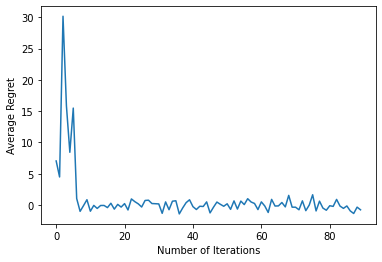

In [15]:
import matplotlib.pyplot as plt

num_iterations = 90 # @param
steps_per_loop = 1 # @param

replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.policy.trajectory_spec,
    batch_size=batch_size,
    max_length=steps_per_loop)

observers = [replay_buffer.add_batch, regret_metric]

driver = dynamic_step_driver.DynamicStepDriver(
    env=environment,
    policy=agent.collect_policy,
    num_steps=steps_per_loop * batch_size,
    observers=observers)

regret_values = []

for _ in range(num_iterations):
  driver.run()
  loss_info = agent.train(replay_buffer.gather_all())
  replay_buffer.clear()
  regret_values.append(regret_metric.result())

plt.plot(regret_values)
plt.ylabel('Average Regret')
plt.xlabel('Number of Iterations')

### **Observation:**
From the above resuting plot, we can see that it shows average Regret is decreasing as the agent is trained further. And the policy gets better in learning the right action to be taken for a given observation as input.